# Life Insurance Customer Churn Analysis


## Introduction

What drives a customer to remain loyal to their insurance provider, and what factors push them to seek alternatives? In the competitive world of insurance, understanding customer behavior is crucial to retaining policyholders and maintaining steady business growth.

This project delves into a dataset centered on life insurance customers, aiming to uncover the key factors influencing customer churn. By analyzing patterns in customer demographics, claims, premiums, and other attributes, we strive to answer critical questions:
- What makes a customer more likely to churn?
- Are there specific premium categories or claim behaviors that signal dissatisfaction?
- What strategies can insurers adopt to retain their customers?

The dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/usmanfarid/customer-churn-dataset-for-life-insurance-industry), offers a snapshot of life insurance customers, including variables such as claim amounts, premium ratios, and churn status. Through this analysis, we hope to shed light on actionable insights that can drive improved customer retention in the insurance industry.

## Table of Contents
1. [Data Wrangling](#Data-Wrangling)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Modeling Process](#Modeling-Process)
4. [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Wrangling
The data wrangling process involved preparing the dataset for analysis by handling missing values, ensuring consistent formatting, and encoding categorical features for compatibility with machine learning models. Key steps included identifying and addressing outliers, verifying the integrity of data distributions, and normalizing numerical values where necessary. The dataset included features such as ```claimreason```, ```dataconfidentiality```, ```bmi```, and ```claimamount```, which were carefully processed to ensure readiness for exploratory data analysis (EDA) and modeling.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the dataset
df = pd.read_csv('customer_churn_dataset.csv')

In [3]:
# Examining the data to make sure everything loaded in as expected
df.head()

,Unnamed: 0,Customer Name,Customer_Address,Company Name,Claim Reason,Data confidentiality,Claim Amount,Category Premium,Premium/Amount Ratio,Claim Request output,BMI,Churn
0,0,Christine Payne,"7627 Anderson Rest Apt. 265,Lake Heather, DC 3...","Williams, Henderson and Perez",Travel,Low,377,4794,0.078640,No,21,Yes
1,1,Tony Fernandez,"3953 Cindy Brook Apt. 147,East Lindatown, TN 4...",Moore-Goodwin,Medical,High,1440,14390,0.100069,No,24,Yes
2,2,Christopher Kim,"8693 Walters Mountains,South Tony, TX 88407",Smith-Holmes,Phone,Medium,256,1875,0.136533,No,18,Yes
3,3,Nicole Allen,"56926 Webster Coves,Shawnmouth, NV 04853",Harrell-Perez,Phone,Medium,233,1875,0.124267,No,24,Yes
4,4,Linda Cruz,"489 Thomas Forges Apt. 305,Jesseton, GA 36765","Simpson, Kramer and Hughes",Phone,Medium,239,1875,0.127467,No,21,Yes


In [4]:
# Checking data types and # of null values in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            200000 non-null  int64  
 1   Customer Name         200000 non-null  object 
 2   Customer_Address      200000 non-null  object 
 3   Company Name          200000 non-null  object 
 4   Claim Reason          200000 non-null  object 
 5   Data confidentiality  200000 non-null  object 
 6   Claim Amount          200000 non-null  int64  
 7   Category Premium      200000 non-null  int64  
 8   Premium/Amount Ratio  200000 non-null  float64
 9   Claim Request output  200000 non-null  object 
 10  BMI                   200000 non-null  int64  
 11  Churn                 200000 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 18.3+ MB


#### Checking for Duplicates
The first thing I checked was whether there were any duplicates in the dataset, and none were found.

In [5]:
duplicates = df.duplicated().sum()
print('There are', duplicates, 'duplicates in this dataset.')

There are 0 duplicates in this dataset.


#### Standardize and Clean Column Names
Renamed columns for readability and consistency. For example, ```Category Premium``` was changed to ```categorypremium```.

In [6]:
# Remove leading/trailing whitespace, slashes, and underscores
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('/', '').str.replace('_', '').str.lower()

# Print the cleaned column names
print(df.columns)

Index(['unnamed:0', 'customername', 'customeraddress', 'companyname',
       'claimreason', 'dataconfidentiality', 'claimamount', 'categorypremium',
       'premiumamountratio', 'claimrequestoutput', 'bmi', 'churn'],
      dtype='object')


#### Creating Customer State Column
Extracting the customer state from the customer address column for potential geographic data insights.

In [7]:
# Create a new column for customerstate by extracting the state abbreviation
df['customerstate'] = df['customeraddress'].str.extract(r'([A-Z]{2})\s*\d{5}')

# Check the first few rows to verify the transformation
print(df[['customerstate']].head())

  customerstate
0            DC
1            TN
2            TX
3            NV
4            GA


#### Extraneous Data
The dataset contains 11 columns and 200,000 rows. After examining the data, there appears to be an extraneous column, ```unnamed:0```, that is not needed for the data analysis and can be removed. The Customer Name and Company Name columns can also be removed since they are irrelevant to the problem we are trying to solve.

In [8]:
# Dropping the Unnamed, Customer Name, and Company Name columns
df.drop(columns=['unnamed:0', 'customername', 'companyname', 'customeraddress'], inplace=True)

#### Checking for Null Values
Next, the dataset is double-checked to ensure that there are no null or blank values. Both the info table above and the output below indicate that the data doesn't have any so we can proceed.

In [9]:
# Checking for any other missing values in the dataset
print(df.isin(['', 'Unknown', 'N/A']).sum())

claimreason            0
dataconfidentiality    0
claimamount            0
categorypremium        0
premiumamountratio     0
claimrequestoutput     0
bmi                    0
churn                  0
customerstate          0
dtype: int64


#### Checking for Non-Boolean Values
The ```claimrequestoutput``` and ```churn``` columns contain boolean values, Yes or No, and will need to be validated to make sure there are no unexpected values.

In [10]:
# Check unique values in ClaimRequestOutput
print("claimrequestoutput unique values:", df['claimrequestoutput'].unique())

# Check unique values in Churn
print("churn unique values:", df['churn'].unique())

claimrequestoutput unique values: ['No' 'Yes']
churn unique values: ['Yes' 'No']


#### Checking for Correct Data Types
The dataset contains incorrect data types in the Claim Reason and Data Confidentiality columns. It is more accurate to type these as category columns instead of object columns.
- Claim Reason: Updated data type from object to category
- Data confidentiality: Updated data type from object to category

In addition, we need to map the Claim Request output and Churn to numerical boolean values (0 or 1) for easier analysis and visualization.

In [11]:
# Re-typing variables
df['claimreason'] = df['claimreason'].astype('category')
df['customerstate'] = df['customerstate'].astype('category')
df['dataconfidentiality'] = df['dataconfidentiality'].astype('category')
df['claimrequestoutput'] = df['claimrequestoutput'].map({'Yes': 1, 'No': 0})
df['churn'] = df['churn'].map({'Yes': 1, 'No': 0})

In [12]:
# Checking the updated info for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   claimreason          200000 non-null  category
 1   dataconfidentiality  200000 non-null  category
 2   claimamount          200000 non-null  int64   
 3   categorypremium      200000 non-null  int64   
 4   premiumamountratio   200000 non-null  float64 
 5   claimrequestoutput   200000 non-null  int64   
 6   bmi                  200000 non-null  int64   
 7   churn                200000 non-null  int64   
 8   customerstate        200000 non-null  category
dtypes: category(3), float64(1), int64(5)
memory usage: 9.7 MB


In [13]:
# Reviewing high-level overview of the quantitative data
df.describe()

,claimamount,categorypremium,premiumamountratio,claimrequestoutput,bmi,churn
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,1120.478840,8963.783895,0.125024,0.035030,23.007205,0.636360
std,796.660796,6114.737202,0.034742,0.183856,3.164976,0.481048
min,1.000000,399.000000,0.002506,0.000000,18.000000,0.000000
25%,245.000000,1875.000000,0.106741,0.000000,20.000000,0.000000
50%,1390.000000,14390.000000,0.125122,0.000000,23.000000,1.000000
75%,1844.000000,14390.000000,0.143155,0.000000,26.000000,1.000000
max,2299.000000,14390.000000,0.248120,1.000000,28.000000,1.000000


#### Identifying Outliers
Below, I have defined and called a function, ```count_outliers```, that prints out the number of outliers (±3 standard deviations outside of the mean) present in any columns we pass in as a parameter. The output reveals that the ```premiumamountratio``` and ```claimrequestoutput``` contain 4,866 and 7,006 outliers respectively and require further investigation before proceeding.

In [14]:
def count_outliers(df, columns, threshold = 3):
    
    for col in columns:
        z_scores = zscore(df[col])
        outliers = (abs(z_scores) > threshold)
        print(f"Number of outliers in {col}: {outliers.sum()}")

count_outliers(df, ['claimamount', 'categorypremium', 'claimrequestoutput', 'premiumamountratio', 'bmi', 'churn'])

Number of outliers in claimamount: 0
Number of outliers in categorypremium: 0
Number of outliers in claimrequestoutput: 7006
Number of outliers in premiumamountratio: 4866
Number of outliers in bmi: 0
Number of outliers in churn: 0


The column ```claimrequestoutput``` has already been verified to only contain 0 or 1 as values. Upon closer inspection of the data, the ```claimrequestoutput``` column is heavily imbalanced, with ~96.5% of rows representing ```0 (No)``` and ~3.5% representing ```1 (Yes)```. This imbalance does not indicate errors but reflects the rarity of approved claims in the dataset. 

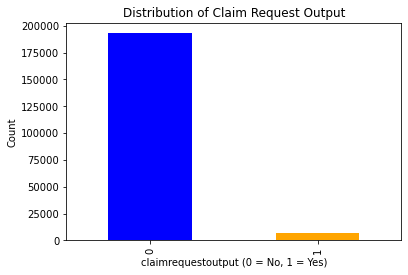

In [15]:
df['claimrequestoutput'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Claim Request Output')
plt.xlabel('claimrequestoutput (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [16]:
print(df['claimrequestoutput'].value_counts(normalize=True))

0    0.96497
1    0.03503
Name: claimrequestoutput, dtype: float64


#### Investigating Premium Amount Ratio
The other column with outliers was ```premiumamountratio```. The data is examined more closely to see if there are any commonalities amongst these rows on a high level.

In [17]:
# Identify rows with outliers in PremiumAmountRatio
z_scores = zscore(df['premiumamountratio'])
premium_outliers = df[np.abs(z_scores) > 3]
print(premium_outliers[['premiumamountratio', 'categorypremium', 'bmi', 'claimamount']].head())

     premiumamountratio  categorypremium  bmi  claimamount
40             0.005013              399   28            2
53             0.233083              399   18           93
139            0.238095              399   26           95
195            0.020050              399   22            8
259            0.017544              399   25            7


#### Exploring the Relationship Between Premium Amount Ratio Outliers and Category Premium
When examining the outliers more closely, it was discovered that all of the outliers belong to a specific policy category, ```399```. 

In [18]:
print(premium_outliers[['categorypremium', 'premiumamountratio', 'churn']].describe())

       categorypremium  premiumamountratio        churn
count           4866.0         4866.000000  4866.000000
mean             399.0            0.124943     0.638923
std                0.0            0.114206     0.480362
min              399.0            0.002506     0.000000
25%              399.0            0.010025     0.000000
50%              399.0            0.020050     1.000000
75%              399.0            0.238095     1.000000
max              399.0            0.248120     1.000000


The churn rate does not appear to differ much between the outlier values and the overall dataset. Thus, I've made the decision to leave these values in since it only represents 2% of the dataset and preserves the integrity of the data.

In [19]:
# Segment the data
policy_399 = df[df['categorypremium'] == 399]
other_policies = df[df['categorypremium'] != 399]

# Compare churn rates
print("Churn Rate for CategoryPremium 399:", policy_399['churn'].mean())
print("Churn Rate for Other Policies:", other_policies['churn'].mean())

Churn Rate for CategoryPremium 399: 0.6361347599960248
Churn Rate for Other Policies: 0.6364000400440485


## Exploratory Data Analysis
The exploratory data analysis focused on understanding customer churn behavior across key variables. Below is a summary of key insights:

The analysis revealed:

1. **BMI's Dominance**: ```bmi``` is the strongest feature, perfectly separating churned and retained customers.
2. **Weak Predictive Power of Other Features**: Features like ```categorypremium```, ```claimreason```, and ```claimamount``` contribute minimally to churn predictions.
3. **Class Imbalance and Overlap**: While ```churn``` is imbalanced (63.6% churn), most features show significant overlap between classes, making them poor predictors.

bmi
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    0
26    0
27    0
28    0
Name: churn, dtype: int64


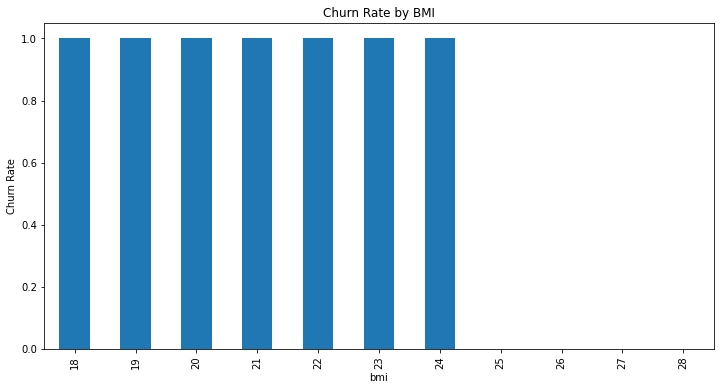

In [20]:
churn_by_bmi = df.groupby('bmi')['churn'].mean().sort_values(ascending=False)
print(churn_by_bmi)
churn_by_bmi.plot(kind='bar', figsize=(12, 6))
plt.title('Churn Rate by BMI')
plt.ylabel('Churn Rate')
plt.show()

categorypremium
4794     0.640743
14390    0.636256
399      0.636135
1875     0.632596
Name: churn, dtype: float64


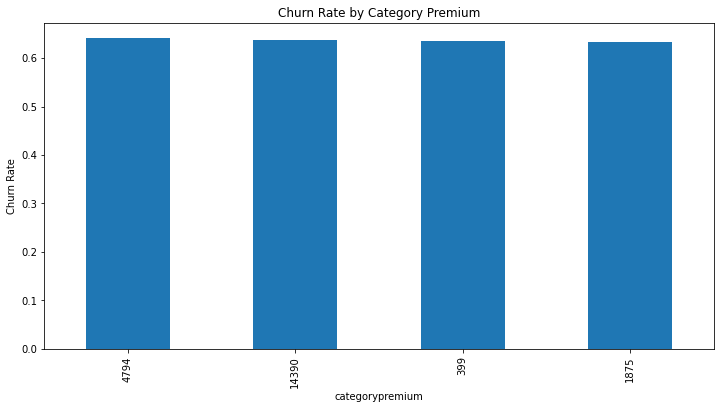

In [21]:
churn_by_category_premium = df.groupby('categorypremium')['churn'].mean().sort_values(ascending=False)
print(churn_by_category_premium)
churn_by_category_premium.plot(kind='bar', figsize=(12, 6))
plt.title('Churn Rate by Category Premium')
plt.ylabel('Churn Rate')
plt.show()

dataconfidentiality
Low         0.640743
High        0.636256
Very low    0.636135
Medium      0.632596
Name: churn, dtype: float64


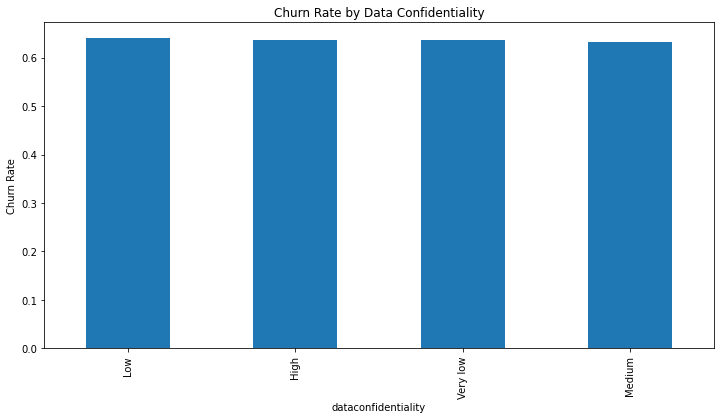

In [22]:
churn_by_data_confidentiality = df.groupby('dataconfidentiality')['churn'].mean().sort_values(ascending=False)
print(churn_by_data_confidentiality)
churn_by_data_confidentiality.plot(kind='bar', figsize=(12, 6))
plt.title('Churn Rate by Data Confidentiality')
plt.ylabel('Churn Rate')
plt.show()

claimrequestoutput
0    0.636414
1    0.634884
Name: churn, dtype: float64


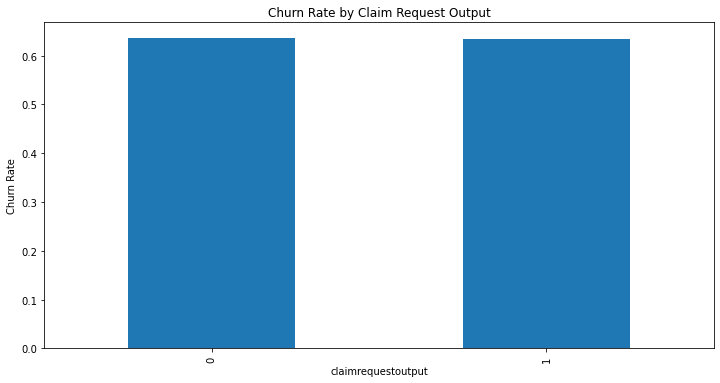

In [23]:
churn_by_claim_request_output = df.groupby('claimrequestoutput')['churn'].mean().sort_values(ascending=False)
print(churn_by_claim_request_output)
churn_by_claim_request_output.plot(kind='bar', figsize=(12, 6))
plt.title('Churn Rate by Claim Request Output')
plt.ylabel('Churn Rate')
plt.show()

claimreason
Travel     0.640743
Medical    0.636256
Other      0.636135
Phone      0.632596
Name: churn, dtype: float64


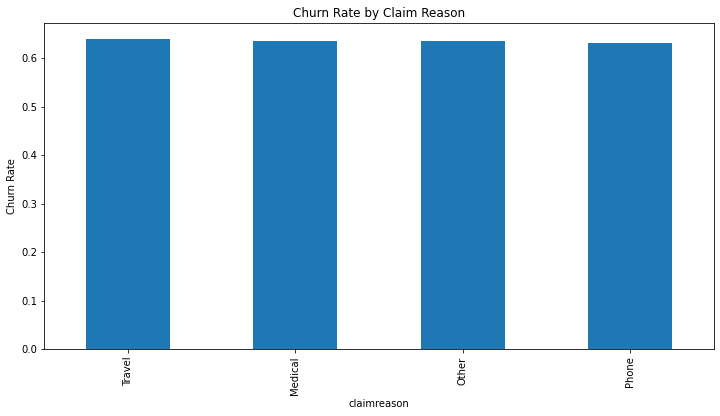

In [24]:
churn_by_claim_reason = df.groupby('claimreason')['churn'].mean().sort_values(ascending=False)
print(churn_by_claim_reason)
churn_by_claim_reason.plot(kind='bar', figsize=(12, 6))
plt.title('Churn Rate by Claim Reason')
plt.ylabel('Churn Rate')
plt.show()

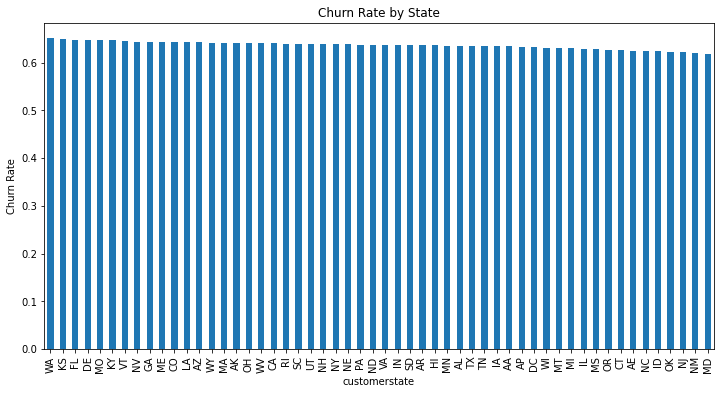

In [25]:
churn_by_state = df.groupby('customerstate')['churn'].mean().sort_values(ascending=False)
churn_by_state.plot(kind='bar', figsize=(12, 6))
plt.title('Churn Rate by State')
plt.ylabel('Churn Rate')
plt.show()

In [26]:
state_churn_rate = df.groupby('customerstate')['churn'].mean().reset_index()
state_churn_rate.to_csv('state_churn_rate.csv', index=False)

#### Visualizing Churn Rates By State
Below is a visualization of the churn rates by US state. Here is a link to the interactive dashboard in Tableau: [Interactive Churn Rate Map](https://public.tableau.com/app/profile/mikayla.bryant/viz/ChurnRatesByStateLifeInsurance/Sheet1#1)

There doesn't appear to be a specific pattern in the data. If there is any correlation, we would need additional data to investigate.
![Churn Rate Map](Churn_Rates_By_State.png)

Healthy        108979
Overweight      72728
Underweight     18293
Name: bmi_category, dtype: int64


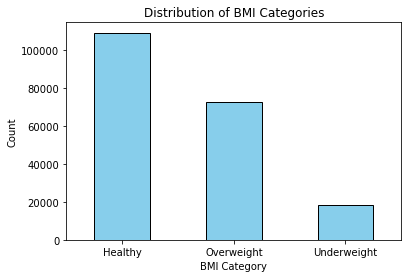

bmi_category
Healthy        1
Overweight     0
Underweight    1
Name: churn, dtype: int64


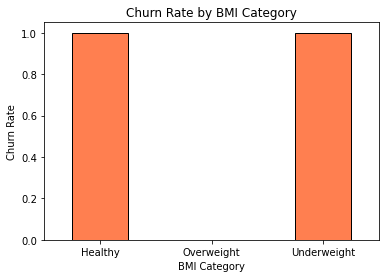

In [27]:
# Define BMI categories based on standard ranges
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Healthy'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obese'

# Apply the function to create a new BMI category column
df['bmi_category'] = df['bmi'].apply(categorize_bmi)

# Verify the distribution of the BMI categories
print(df['bmi_category'].value_counts())

df['bmi_category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of BMI Categories')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Group by BMI category and calculate churn rates
bmi_churn_rate = df.groupby('bmi_category')['churn'].mean()

# Print churn rates for each BMI category
print(bmi_churn_rate)

bmi_churn_rate.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Churn Rate by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

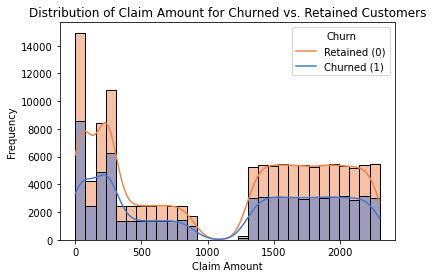

Mean Claim Amount by Churn Status:
churn
0    1119.940436
1    1120.786504
Name: claimamount, dtype: float64

Median Claim Amount by Churn Status:
churn
0    1390
1    1389
Name: claimamount, dtype: int64


In [28]:
# Plot distribution of claimamount for churned and retained customers
sns.histplot(data=df, x='claimamount', hue='churn', kde=True, bins=30, palette='muted')
plt.title('Distribution of Claim Amount for Churned vs. Retained Customers')
plt.xlabel('Claim Amount')
plt.ylabel('Frequency')
plt.legend(title='Churn', labels=['Retained (0)', 'Churned (1)'])
plt.show()

# Calculate mean and median claim amounts for churned vs. retained customers
mean_claim = df.groupby('churn')['claimamount'].mean()
median_claim = df.groupby('churn')['claimamount'].median()

print("Mean Claim Amount by Churn Status:")
print(mean_claim)

print("\nMedian Claim Amount by Churn Status:")
print(median_claim)

## Modeling Process

The goal of the modeling process was to build a logistic regression model to predict customer churn based on the given features. The process included:

1. **Feature Engineering**: Numerical features were passed through as-is, while categorical features (claimreason, dataconfidentiality, customerstate) were one-hot encoded.
2. **Training and Testing Split**: The data was split into training (80%) and testing (20%) sets, ensuring the class distribution was preserved using stratification.
3. **Model Training**: A logistic regression model was trained using the processed features. However, the model achieved perfect accuracy, indicating potential overfitting due to the dominance of bmi. Further steps included re-evaluating the feature set to mitigate this effect and assess the model's performance more realistically.

The modeling process underscores the importance of balancing feature influence and addressing potential pitfalls such as feature dominance and class imbalance.

In [29]:
# Define the categorical and numerical columns
categorical_columns = ['claimreason', 'dataconfidentiality', 'customerstate']
numerical_columns = ['bmi', 'claimamount', 'categorypremium', 'premiumamountratio', 'claimrequestoutput']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

# Split data into features and target
X = df.drop('churn', axis=1)  # Features
y = df['churn']              # Target for prediction

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocess the training and testing features
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train logistic regression model on the training data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_preprocessed, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_preprocessed)

In [30]:
# Add churn back into the features for correlation check
X_with_target = X.copy()
X_with_target['churn'] = y

# Calculate correlations
correlations = X_with_target.corr()['churn'].sort_values(ascending=False)

# Print correlations
print("Feature correlations with churn:\n", correlations)

Feature correlations with churn:
 churn                 1.000000
premiumamountratio    0.000772
claimamount           0.000511
categorypremium       0.000425
claimrequestoutput   -0.000584
bmi                  -0.836014
Name: churn, dtype: float64


## Conclusions and Recommendations
The analysis revealed that BMI fully predicts customer churn in the dataset: customers with a BMI under 25 always churn, while those with a BMI of 25 or higher never churn. This finding is unusual and suggests the mock dataset may be a poorly constructed. Such a strong, perfect relationship is rare in real-world data and warrants further investigation. However, if this data were legitimate, it would point to a highly significant relationship between BMI and churn, likely reflecting deeper, underlying patterns in customer behavior, health, or satisfaction.

### Verifying the Dataset
To address the possibility of a flawed dataset, the company should begin by auditing its data collection processes. This includes verifying how BMI and churn data were collected, ensuring no biases or errors occurred during sampling or entry, and confirming the accuracy of recorded values. Collaboration with customer-facing teams, such as customer service or marketing, could provide qualitative insights into whether BMI legitimately impacts customer satisfaction and retention.

### Addressing Churn if the Data is Legitimate
If further verification supports the legitimacy of the dataset, the company should explore the reasons behind such a strong relationship by engaging directly with customers in the under-25 BMI group. Surveys or interviews could shed light on their preferences, needs, and pain points, helping the company better understand why they are more likely to churn. To address these concerns, the company could develop targeted strategies for retention. For instance, tailored health and wellness programs, such as fitness-related incentives or discounts on health services, could resonate with this customer group. Enhanced communication and engagement, including proactive support and personalized offers, may also address potential dissatisfaction early. Additionally, the company could review its products and services to ensure they meet the unique needs of this demographic, potentially introducing offerings better suited to their preferences. Loyalty programs that reward consistent engagement might further encourage retention among this group.

[Back to Top](#Introduction)